In [2]:
# note for team: download the dataset zip from kaggle
# create a folder in the same root folder as this file called "dataset"
# unzip the downloaded data in that dataset folder and everything else should work
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
from category_encoders import TargetEncoder
import joblib


In [4]:
all_airlines = pd.read_csv("dataset/archive/Airlines.csv")
print(all_airlines.head())
print(all_airlines.describe())

  Code                    Description
0  02Q                  Titan Airways
1  04Q             Tradewind Aviation
2  05Q            Comlux Aviation, AG
3  06Q  Master Top Linhas Aereas Ltd.
4  07Q            Flair Airlines Ltd.
        Code           Description
count   1570                  1571
unique  1570                  1571
top      ZYZ  Skyway Aviation Inc.
freq       1                     1


In [5]:
flight_data = pd.read_csv("dataset/archive/Combined_Flights_2022.csv")
print(flight_data.head())
print(flight_data.describe())

   FlightDate                                    Airline Origin Dest  \
0  2022-04-04  Commutair Aka Champlain Enterprises, Inc.    GJT  DEN   
1  2022-04-04  Commutair Aka Champlain Enterprises, Inc.    HRL  IAH   
2  2022-04-04  Commutair Aka Champlain Enterprises, Inc.    DRO  DEN   
3  2022-04-04  Commutair Aka Champlain Enterprises, Inc.    IAH  GPT   
4  2022-04-04  Commutair Aka Champlain Enterprises, Inc.    DRO  DEN   

   Cancelled  Diverted  CRSDepTime  DepTime  DepDelayMinutes  DepDelay  ...  \
0      False     False        1133   1123.0              0.0     -10.0  ...   
1      False     False         732    728.0              0.0      -4.0  ...   
2      False     False        1529   1514.0              0.0     -15.0  ...   
3      False     False        1435   1430.0              0.0      -5.0  ...   
4      False     False        1135   1135.0              0.0       0.0  ...   

   WheelsOff  WheelsOn  TaxiIn  CRSArrTime  ArrDelay  ArrDel15  \
0     1140.0    1220.0    

In [6]:
missing_values_per_column = flight_data.isna().any(axis=0)
print(missing_values_per_column)

FlightDate            False
Airline               False
Origin                False
Dest                  False
Cancelled             False
                      ...  
ArrDel15               True
ArrivalDelayGroups     True
ArrTimeBlk            False
DistanceGroup         False
DivAirportLandings    False
Length: 61, dtype: bool


In [7]:
print(flight_data['Origin'].nunique())
print(flight_data['Dest'].nunique())

# There's 375 different airport codes which is too much to reliably encode. I found this dataset: https://github.com/ip2location/ip2location-iata-icao/blob/master/iata-icao.csv
# which gives you the geographic location (lon, lat) of each airport code. So we'll map the code to a geographic location. Add a file called "airport-codes" in the "archive" file
# add only the csv file or move it back one folder if you downloaded zip (should be /archive/airport-codes/iata-icao.csv)
airport_codes = pd.read_csv("dataset/archive/airport-codes/iata-icao.csv")
print(airport_codes.head())
airport_codes_indexed = airport_codes.set_index("iata")

# If it seems like it's taking forever or like something is broken, going to "Run" -> "Restart Kernel and Run All Cells" worked for me
mapping_dict_lat = airport_codes_indexed["latitude"].to_dict()
mapping_dict_lon = airport_codes_indexed["longitude"].to_dict()
flight_data["Origin_Lat"] = flight_data["Origin"].map(mapping_dict_lat)
flight_data["Origin_Lon"] = flight_data["Origin"].map(mapping_dict_lon)

flight_data["Dest_Lat"] = flight_data["Dest"].map(mapping_dict_lat)
flight_data["Dest_Lon"] = flight_data["Dest"].map(mapping_dict_lon)

print(flight_data.head())

# Add a column that gives us our target delay prediction time including the total delay (will be negative if early arrival)
flight_data["TotalDelay"] = flight_data["ActualElapsedTime"] - flight_data["CRSElapsedTime"]
print(flight_data["TotalDelay"].head())

# Replace any unknown delays with 0 - might want to improve this logic (there might be other info we can derive delay from for only the na values)
flight_data["TotalDelay"] = np.nan_to_num(flight_data["TotalDelay"])

375
375
  country_code region_name iata  icao                          airport  \
0           AE    Abu Zaby  AAN  OMAL     Al Ain International Airport   
1           AE    Abu Zaby  AUH  OMAA  Abu Dhabi International Airport   
2           AE    Abu Zaby  AYM   NaN         Yas Island Seaplane Base   
3           AE    Abu Zaby  AZI  OMAD      Al Bateen Executive Airport   
4           AE    Abu Zaby  DHF  OMAM               Al Dhafra Air Base   

   latitude  longitude  
0   24.2617    55.6092  
1   24.4330    54.6511  
2   24.4670    54.6103  
3   24.4283    54.4581  
4   24.2482    54.5477  
   FlightDate                                    Airline Origin Dest  \
0  2022-04-04  Commutair Aka Champlain Enterprises, Inc.    GJT  DEN   
1  2022-04-04  Commutair Aka Champlain Enterprises, Inc.    HRL  IAH   
2  2022-04-04  Commutair Aka Champlain Enterprises, Inc.    DRO  DEN   
3  2022-04-04  Commutair Aka Champlain Enterprises, Inc.    IAH  GPT   
4  2022-04-04  Commutair Aka Champlai

In [ ]:
# normalize the weather delay column to 0-1 to match the normalized value on the website backend  (I
# basically just made the delay in minutes correspond to the severity of weather (clear skies, thunderstorm, etc.)

#removing this for now - can
#min_val = np.min(flight_data["TotalDelay"])
#max_val = np.max(flight_data["TotalDelay"])

# Apply the min-max normalization formula
#flight_data["WeatherScore"] = (flight_data["TotalDelay"] - min_val) / (max_val - min_val)

#print("Normalized data:", flight_data["WeatherScore"].head())
#print("DepDelay_Normalized:", np.unique(flight_data["WeatherScore"], return_counts=True))


In [8]:
# Sampling and finding correlation
sampled_flight_data = flight_data.sample(frac=0.1, random_state=16)


numerical_cols = sampled_flight_data.select_dtypes(include=np.number).columns
correlation_matrix = sampled_flight_data[numerical_cols].corr()
total_delay_correlation = correlation_matrix['TotalDelay'].sort_values(ascending=False)

print("Correlation with TotalDelay (10% sample):")
print(total_delay_correlation)

Correlation with TotalDelay (10% sample):
TotalDelay                         1.000000
TaxiOut                            0.547675
TaxiIn                             0.387288
ArrivalDelayGroups                 0.365868
ArrDel15                           0.340346
ArrDelay                           0.276056
ArrDelayMinutes                    0.186942
ActualElapsedTime                  0.084481
DOT_ID_Operating_Airline           0.081094
DOT_ID_Marketing_Airline           0.070575
WheelsOn                           0.040135
WheelsOff                          0.039389
ArrTime                            0.037470
Month                              0.034045
DepartureDelayGroups               0.032663
Dest_Lon                           0.031623
Quarter                            0.029448
DepDelayMinutes                    0.027454
DepDelay                           0.026577
DepDel15                           0.025767
CRSArrTime                         0.024733
DepTime                           

/tmp/ipython-input-4293057544.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_flight_data.dropna(subset=selected_columns, inplace=True)


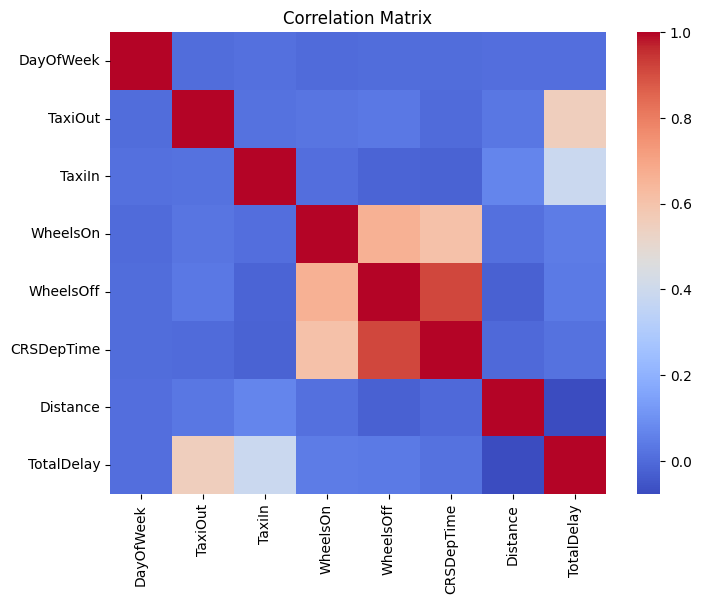

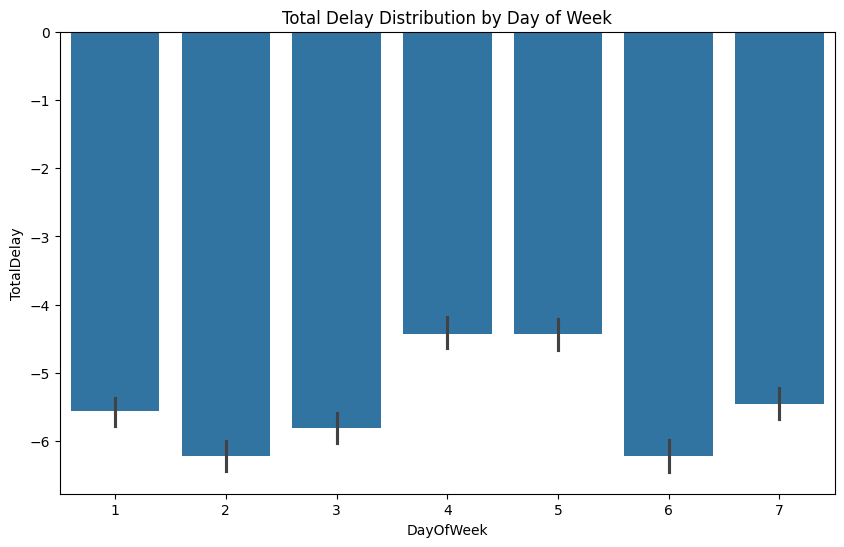

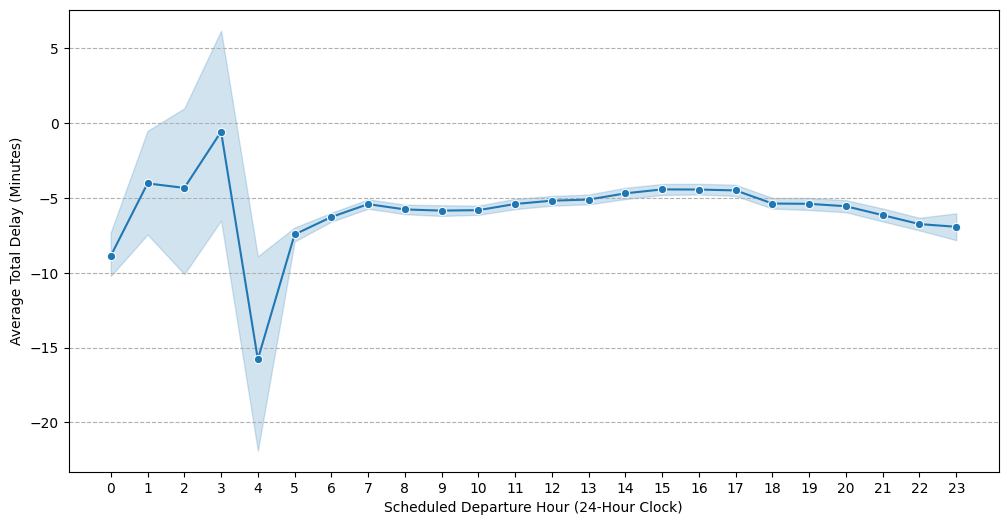

New DataFrame with selected columns:


,DayOfWeek,TaxiOut,TaxiIn,WheelsOn,WheelsOff,CRSDepTime,Distance,Origin,Dest,IATA_Code_Marketing_Airline,TotalDelay
0,1,17.0,8.0,1220.0,1140.0,1133,212.0,GJT,DEN,UA,-7.0
1,1,16.0,9.0,839.0,744.0,732,295.0,HRL,IAH,UA,3.0
2,1,21.0,14.0,1622.0,1535.0,1529,251.0,DRO,DEN,UA,12.0
3,1,16.0,4.0,1543.0,1446.0,1435,376.0,IAH,GPT,UA,-13.0
4,1,19.0,8.0,1243.0,1154.0,1135,251.0,DRO,DEN,UA,6.0


In [9]:
# The columns I (Hunter) chose to use for training, we can talk about changing this in future meetings
selected_columns = ['DayOfWeek', 'TaxiOut', 'TaxiIn', 'WheelsOn', 'WheelsOff',
                    'CRSDepTime','Distance', 'Origin', 'Dest', 'IATA_Code_Marketing_Airline',
                    'TotalDelay']
filtered_flight_data = flight_data[selected_columns]
filtered_flight_data.dropna(subset=selected_columns, inplace=True)


import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = filtered_flight_data.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

#sns.barplot(x="Month", y="TotalDelay", data=filtered_flight_data)
#plt.title("Month vs. Total Delay")
#plt.show()

sampled_data = filtered_flight_data.sample(n=100000, random_state=42)
plt.figure(figsize=(10, 6))
sns.barplot(x="DayOfWeek", y="TotalDelay", data=sampled_data)
plt.title("Total Delay Distribution by Day of Week")
plt.show()

sampled_data['CRSDepHour'] = sampled_data['CRSDepTime'] // 100
plt.figure(figsize=(12, 6))
sns.lineplot(x="CRSDepHour", y="TotalDelay", data=sampled_data, marker='o')
plt.xlabel("Scheduled Departure Hour (24-Hour Clock)")
plt.ylabel("Average Total Delay (Minutes)")
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--')
plt.show()

print("New DataFrame with selected columns:")
display(filtered_flight_data.head())

In [12]:
# Makes pipeline that converts the time to a more applicable format

def convert_to_minutes(x):
  """Converts the hhmm format into minutes"""
  df = x.copy()
  for column in df.columns:
    hh = (df[column] // 100).astype(int)
    mm = (df[column] % 100).astype(int)
    df[column] = hh * 60 + mm
  return df

airport_specific_encoder = TargetEncoder()

time_feature = ['CRSDepTime', 'WheelsOn', 'WheelsOff',]
numerical_features = ['Distance', 'TaxiOut', 'TaxiIn',]
Categorial_features = ['DayOfWeek']
airport_specific_features = ['Origin', 'Dest', 'IATA_Code_Marketing_Airline']

time_pipeline = Pipeline(steps=[
    ('timeconvert', FunctionTransformer(convert_to_minutes, feature_names_out='one-to-one')),
    ('scale', StandardScaler())
])

model = ColumnTransformer(
    transformers=[
        ('time_pipe', time_pipeline, time_feature),
        ('scaler', StandardScaler(), numerical_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), Categorial_features),
        ('target_encode', airport_specific_encoder, airport_specific_features)
    ],
    verbose_feature_names_out=False
)

model_random_forest = Pipeline([
    ('preprocess', model),
    ('rf', RandomForestRegressor(
        n_estimators=200))])

# XGB model pipeline
model_xgb = Pipeline([
    ('preprocess', model),
    ('xgb', XGBRegressor(
        n_estimators=1000,
        random_state=16,
        verbosity=0
    ))
])

# parm distribution for random search
param_distributions = {
    'xgb__max_depth': randint(3, 15),
    'xgb__learning_rate': uniform(0.01, 0.2),
    'xgb__subsample': uniform(0.6, 0.4),
    'xgb__colsample_bytree': uniform(0.6, 0.4)
}

# random search to optimize parms of XGB pipeline
random_search = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=2,
    verbose=3,
    n_jobs=1,
    random_state=16
)

In [11]:
# Last step before training, just set up training, testing, and validation data.
# BEFORE TRAINING: Need to remove any unwanted x (input) columns and finish cleaning the data
sampled_filtered_flight_data = filtered_flight_data.sample(frac=0.1, random_state=16) # Sampling to make faster training to test if pipeline
y = sampled_filtered_flight_data["TotalDelay"]
X = sampled_filtered_flight_data.drop(columns=['TotalDelay'])

X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                   random_state=16,
                                   test_size=0.2,
                                   shuffle=True)



split_index = len(y_test) // 2

print(f"Original test data length: {len(X_test)}")

X_test_new = X_test[:split_index]
y_test_new = y_test[:split_index]

X_validation = X_test[split_index:]
y_validation = y_test[split_index:]

print(f"Final test data length x: {len(X_test_new)}")
print(f"Final test data length y: {len(y_test_new)}")
print(f"Final validation data length x: {len(X_validation)}")
print(f"Final validation data length y: {len(y_validation)}")

Original test data length: 79082
Final test data length x: 39541
Final test data length y: 39541
Final validation data length x: 39541
Final validation data length y: 39541


In [13]:
# Training of random forest model (Takes long time)
model_random_forest.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('time_pipe',
                                                  Pipeline(steps=[('timeconvert',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function convert_to_minutes at 0x7eccc30132e0>)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['CRSDepTime', 'WheelsOn',
                                                   'WheelsOff']),
                                                 ('scaler', StandardScaler(),
                                                  ['Distance', 'TaxiOut',
                                                   'TaxiIn']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['DayOfWeek']),
                                                 ('target_encode',
                                                  TargetEncoder(),
                                                  ['Origin', 'Dest',
                                                   'IATA_Code_Marketing_Airline'])],
                                   verbose_feature_names_out=False)),
                ('rf', RandomForestRegressor(n_estimators=200))])

In [16]:
# Training of XGB model (Takes long time)
random_search.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2] END xgb__colsample_bytree=0.6893164316614155, xgb__learning_rate=0.11463266828013523, xgb__max_depth=4, xgb__subsample=0.7234467120337544;, score=-6.269 total time=  14.1s
[CV 2/2] END xgb__colsample_bytree=0.6893164316614155, xgb__learning_rate=0.11463266828013523, xgb__max_depth=4, xgb__subsample=0.7234467120337544;, score=-6.253 total time=  13.3s
[CV 1/2] END xgb__colsample_bytree=0.6556778292677665, xgb__learning_rate=0.15089282784325025, xgb__max_depth=3, xgb__subsample=0.8754904647285426;, score=-6.357 total time=  10.2s
[CV 2/2] END xgb__colsample_bytree=0.6556778292677665, xgb__learning_rate=0.15089282784325025, xgb__max_depth=3, xgb__subsample=0.8754904647285426;, score=-6.351 total time=  10.7s
[CV 1/2] END xgb__colsample_bytree=0.6654925700003597, xgb__learning_rate=0.024064973361100063, xgb__max_depth=7, xgb__subsample=0.8742086576333087;, score=-6.260 total time=  26.0s
[CV 2/2] END xgb__colsample_bytre

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('time_pipe',
                                                                               Pipeline(steps=[('timeconvert',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<function convert_to_minutes at 0x7eccc30132e0>)),
                                                                                               ('scale',
                                                                                                StandardScaler())]),
                                                                               ['CRSDepTime',
                                                                                'WheelsOn',
                                                                                'WheelsOff']),
                                                                              ('scaler',
                                                                               StandardScaler(),
                                                                               ['Distance',...
                                        'xgb__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7eccc2eaf4a0>,
                                        'xgb__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7eccc3c82390>,
                                        'xgb__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7eccc300d310>},
                   random_state=16, scoring='neg_mean_absolute_error',
                   verbose=3)

In [15]:
# prediction testing for random forest
y_test_pred = model_random_forest.predict(X_test_new)

print("Test MAE:", mean_absolute_error(y_test_new, y_test_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test_new, y_test_pred)))
print("Test R2:", r2_score(y_test_new, y_test_pred))

Test MAE: 6.36995584962444
Test RMSE: 8.81608400185971
Test R2: 0.5859640646296453


In [17]:
# prediction testing for XGB
y_test_pred = random_search.predict(X_test_new)

print("Test MAE:", mean_absolute_error(y_test_new, y_test_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test_new, y_test_pred)))
print("Test R2:", r2_score(y_test_new, y_test_pred))

Test MAE: 5.3783211123892425
Test RMSE: 7.521263839464724
Test R2: 0.6986520478694949


In [19]:
# Chosen model: XGB
y_val_pred = random_search.predict(X_validation)

print("Validation MAE:", mean_absolute_error(y_validation, y_val_pred))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_validation, y_val_pred)))
print("Validation R2:", r2_score(y_validation, y_val_pred))


Validation MAE: 5.447922003498376
Validation RMSE: 7.647036634074194
Validation R2: 0.6998862334696361


In [ ]:
joblib.dump(random_search, "model.pkl")

In [ ]:
# needs function defined, this allows cell to be ran without running the pipeline cell
def convert_to_minutes(x):
  """Converts the hhmm format into minutes"""
  df = x.copy()
  for column in df.columns:
    hh = (df[column] // 100).astype(int)
    mm = (df[column] % 100).astype(int)
    df[column] = hh * 60 + mm
  return df
random_search = joblib.load('model.pkl')

In [ ]:
# prediction testing for XGB
y_test_pred = random_search.predict(X_test_new)

print("Test MAE:", mean_absolute_error(y_test_new, y_test_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test_new, y_test_pred)))
print("Test R2:", r2_score(y_test_new, y_test_pred))

Test MAE: 6.274094963357567
Test RMSE: 8.605072770002566
Test R2: 0.60554661079463
